# 신용카드 사기 거래 탐지 AI 경진대회

`-` 월간데이콘23 | 비지도 학습 | 이상 탐지 | 정형 | macro-f1 

## 패키지 import

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings(action='ignore')

In [2]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-credit-card-fraud-detection'

In [3]:
train = pd.read_csv('./Data/train.csv')
valid = pd.read_csv('./Data/val.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [4]:
train.drop('ID', axis=1, inplace=True)
valid.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

`-` test 데이터를 제외한 데이터를 train 데이터와 valid 데이터로 무작위로 나눴다 (내 생각)

`-` label이 valid 데이터에만 있어서 우선 valid 데이터를 탐색하겠다

In [5]:
valid.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
count,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,...,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000,28462.000000
mean,0.004967,0.002014,0.001414,0.001893,-0.003969,-0.017730,0.005556,0.009023,-0.004905,-0.002299,...,0.001224,0.001490,0.001355,0.002284,0.000520,-0.000520,-0.000265,0.924010,0.119916,0.001054
std,1.930640,1.605198,1.499749,1.405139,1.335147,1.292214,1.165132,1.103538,1.090843,1.084560,...,0.721350,0.588076,0.603181,0.526864,0.484804,0.394235,0.304284,3.347555,0.558246,0.032449
min,-29.516123,-38.305310,-30.177317,-5.071241,-21.577019,-16.172614,-31.197329,-26.278007,-9.462573,-22.187089,...,-8.555808,-25.356744,-2.807897,-6.035054,-1.596493,-9.793568,-8.364853,-0.307413,-0.994878,0.000000
25%,-0.915525,-0.598053,-0.873022,-0.852444,-0.698010,-0.774920,-0.546290,-0.210941,-0.642760,-0.540463,...,-0.542624,-0.160418,-0.352310,-0.322098,-0.328638,-0.071787,-0.052361,-0.226927,-0.357884,0.000000
50%,0.023586,0.075470,0.175784,-0.021619,-0.052780,-0.280742,0.046280,0.022622,-0.066623,-0.099386,...,0.008401,-0.011372,0.040076,0.016684,-0.049583,0.000488,0.012138,0.005589,0.002156,0.000000
75%,1.315578,0.803463,1.011563,0.739044,0.598712,0.377266,0.566825,0.323836,0.596308,0.452763,...,0.528163,0.146094,0.441402,0.352930,0.241051,0.089100,0.080822,0.778278,0.641828,0.000000
max,2.411769,16.497472,4.226108,12.114672,24.345310,12.128950,26.237722,12.431140,7.937413,12.161890,...,6.090514,18.946734,3.658746,5.525093,3.067907,8.708972,15.726807,165.948299,1.034975,1.000000


In [6]:
valid.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


`-` 각 컬럼이 PCA 변환을 거쳤음 (직접 PCA를 해보니 V28 $\to$ V1 순으로 설명 가능한 분산이 많다)

`-` Class는 0이 정상이고 1이 비정상이다

In [7]:
valid.shape

(28462, 31)

`-` 행은 28462개, 컬럼은 31개

In [8]:
valid.isnull().values.any()

False

`-` 결측치는 없다

## 시각화

In [9]:
valid['Class'].value_counts() / len(valid)

0    0.998946
1    0.001054
Name: Class, dtype: float64

`-` 정상은 $99.8946\%$, 비정상은 $0.1054\%$ 존재한다 (비정상 클래스 개수는 30개)

`-` 비정상 클래스의 비율이 매우 적어 감지하기 어려울 것으로 판단된다

`-` 정상 클래스와 비정상 클래스의 분포를 시각화하자

- 히스토그램

In [10]:
def show_distplot(df_: pd.DataFrame, row:int, column: int, target: str) -> None:
    """ target 범주에 따른 양적 변수의 분포를 distplot을 사용해 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거

    fig, axs = plt.subplots(row, column, figsize=(14, 30))
    features = df.columns[(df.dtypes == float)]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        normal = df[df[target]==0][feature]
        fraud = df[df[target]==1][feature]
        sns.distplot(normal, color='b', label='Normal', ax=ax)
        sns.distplot(fraud, color='r', label='Anomaly', ax=ax)
        ax.axvline(x=np.max(normal), color='b', linestyle='--')
        ax.axvline(x=np.min(normal), color='b', linestyle='--')
        ax.axvline(x=np.max(fraud), color='r', linestyle='--')
        ax.axvline(x=np.min(fraud), color='r', linestyle='--')
        ax.legend()

    ## 남는 서브 플랏은 삭제하자
    for ax in axs: ## axs의 row
        for k in list(range(column)): ## axs의 column
            if not ax[k].has_data(): ## ax[k]에 오브젝트가 없다면
                fig.delaxes(ax[k]) ## 남는 서브 플랏이니 삭제한다
                
    fig.suptitle("Dist Plot\n", x=0.53, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

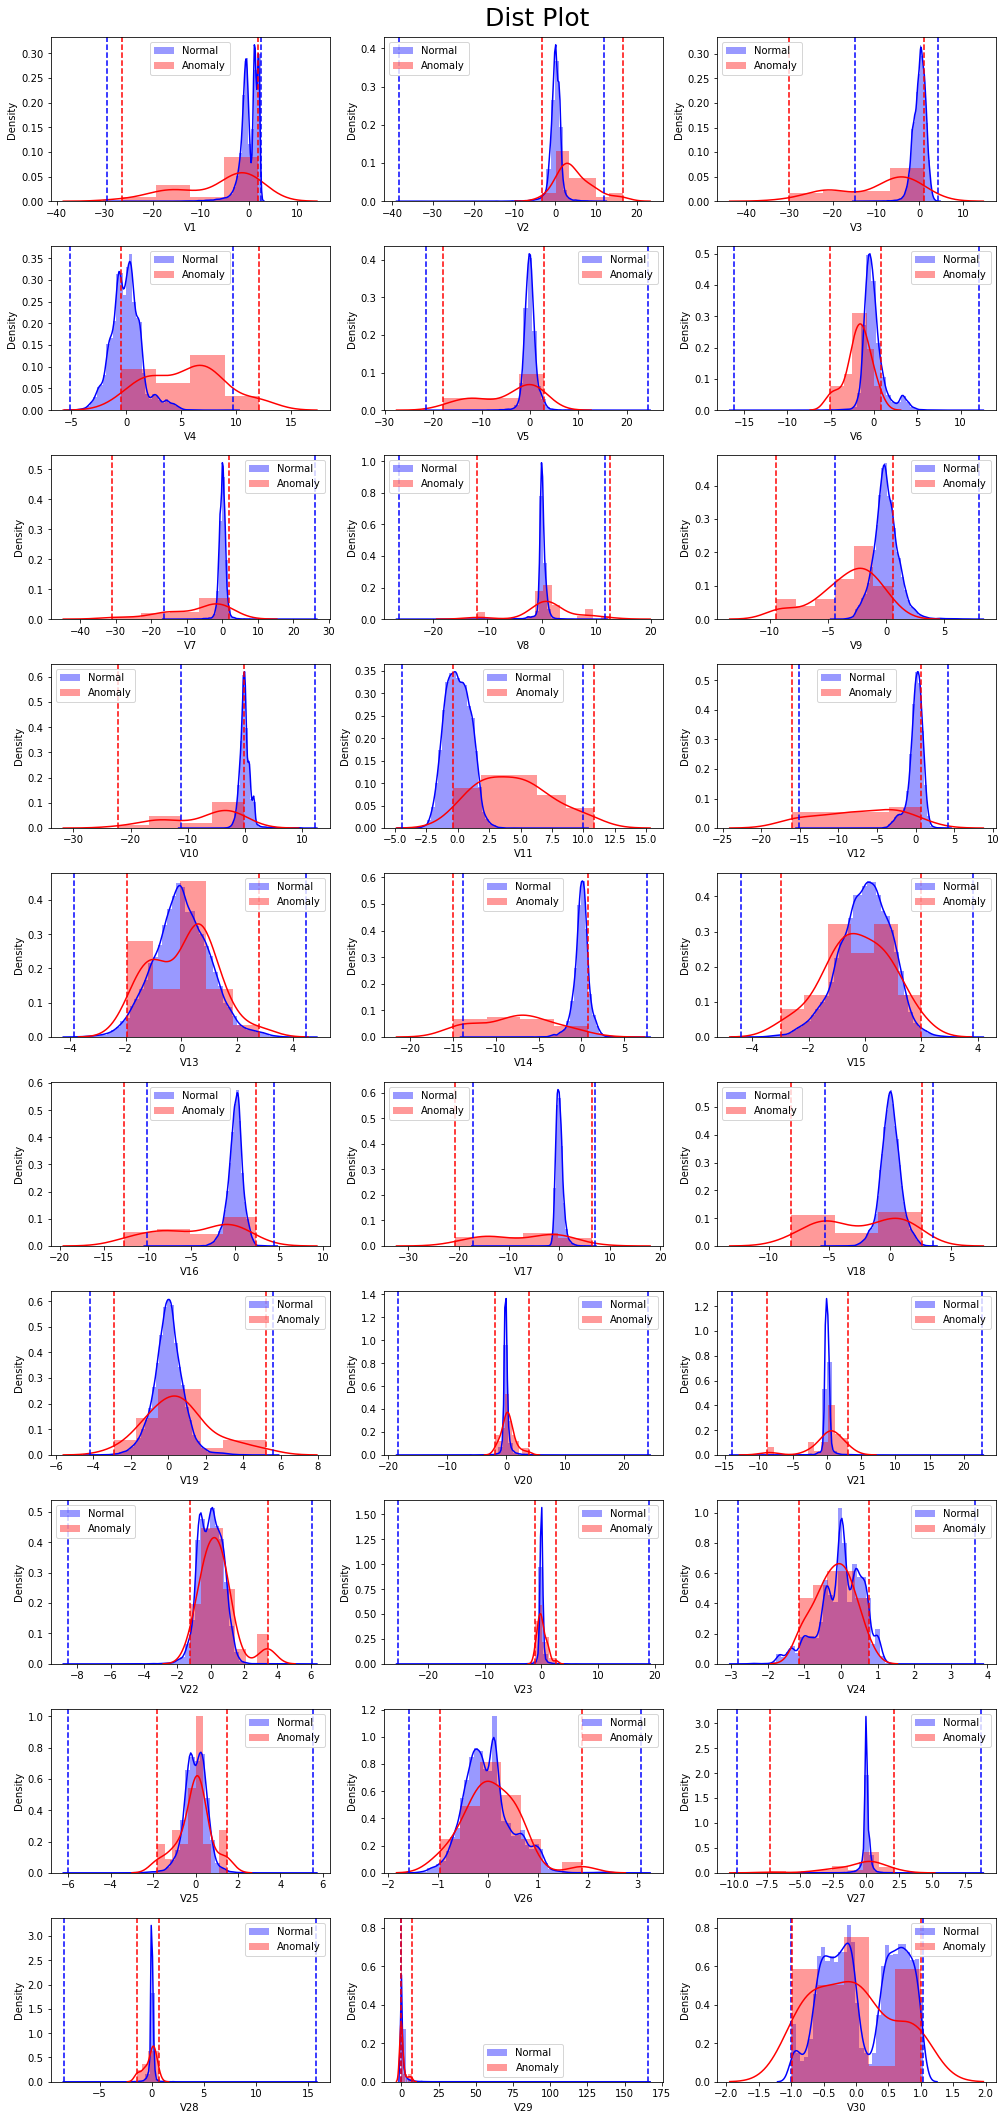

In [11]:
show_distplot(valid, row=10, column=3, target='Class')

`-` 정상 클래스의 분포는 V30을 제외하곤 종모양이다 (V30은 양봉분포)

`-` 비정상 클래스의 분포는 종모양인 경우와 분산이 큰 대칭인 분포인 경우가 존재한다

`-` 둘의 분포가 겹쳐있는 피쳐의 경우 클래스를 분류하는데 효과적이지 못할 것이다

- 상자 그림

In [7]:
def show_boxplot(df_: pd.DataFrame, row:int, column: int, target: str) -> None:
    """ target 범주에 따른 양적 변수의 분포를 boxplot을 사용해 시각화하는 함수"""
    df = df_.copy()
    df = df.dropna() ## 결측치 제거

    fig, axs = plt.subplots(row, column, figsize=(14, 30))
    features = df.columns[(df.dtypes == float)]
    
    for i, feature in enumerate(features):
        ax = axs[i // column][i % column]
        normal = df[df[target]==0][feature]
        fraud = df[df[target]==1][feature]
        sns.boxplot(data=df, x=target, y=feature, ax=ax)

    ## 남는 서브 플랏은 삭제하자
    for ax in axs: ## axs의 row
        for k in list(range(column)): ## axs의 column
            if not ax[k].has_data(): ## ax[k]에 오브젝트가 없다면
                fig.delaxes(ax[k]) ## 남는 서브 플랏이니 삭제한다
                
    fig.suptitle("Box Plot\n", x=0.53, fontsize=25) ## default: x=0.5, y=0.98
    fig.tight_layout()

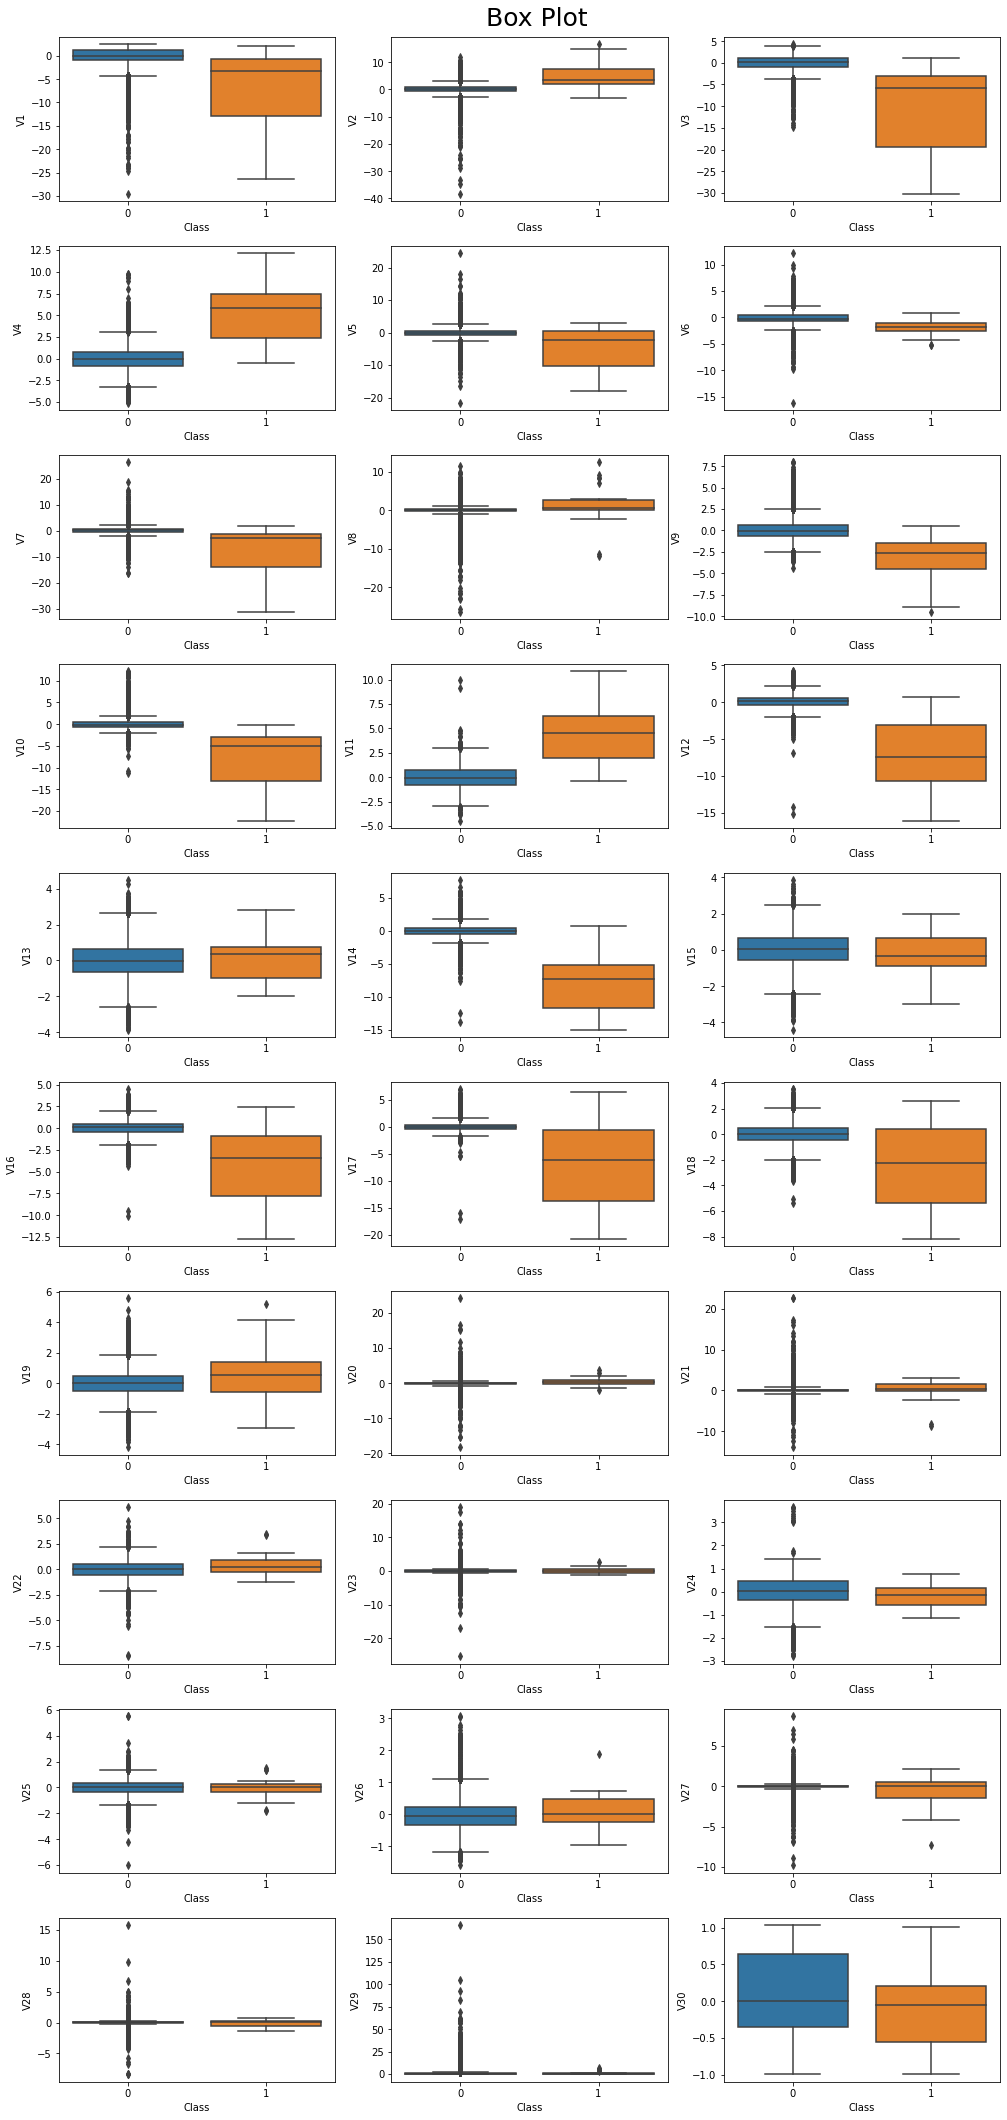

In [9]:
show_boxplot(valid, row=10, column=3, target='Class')

- 상관계수 히트맵

Text(0.5, 1.0, 'Correlation between features')

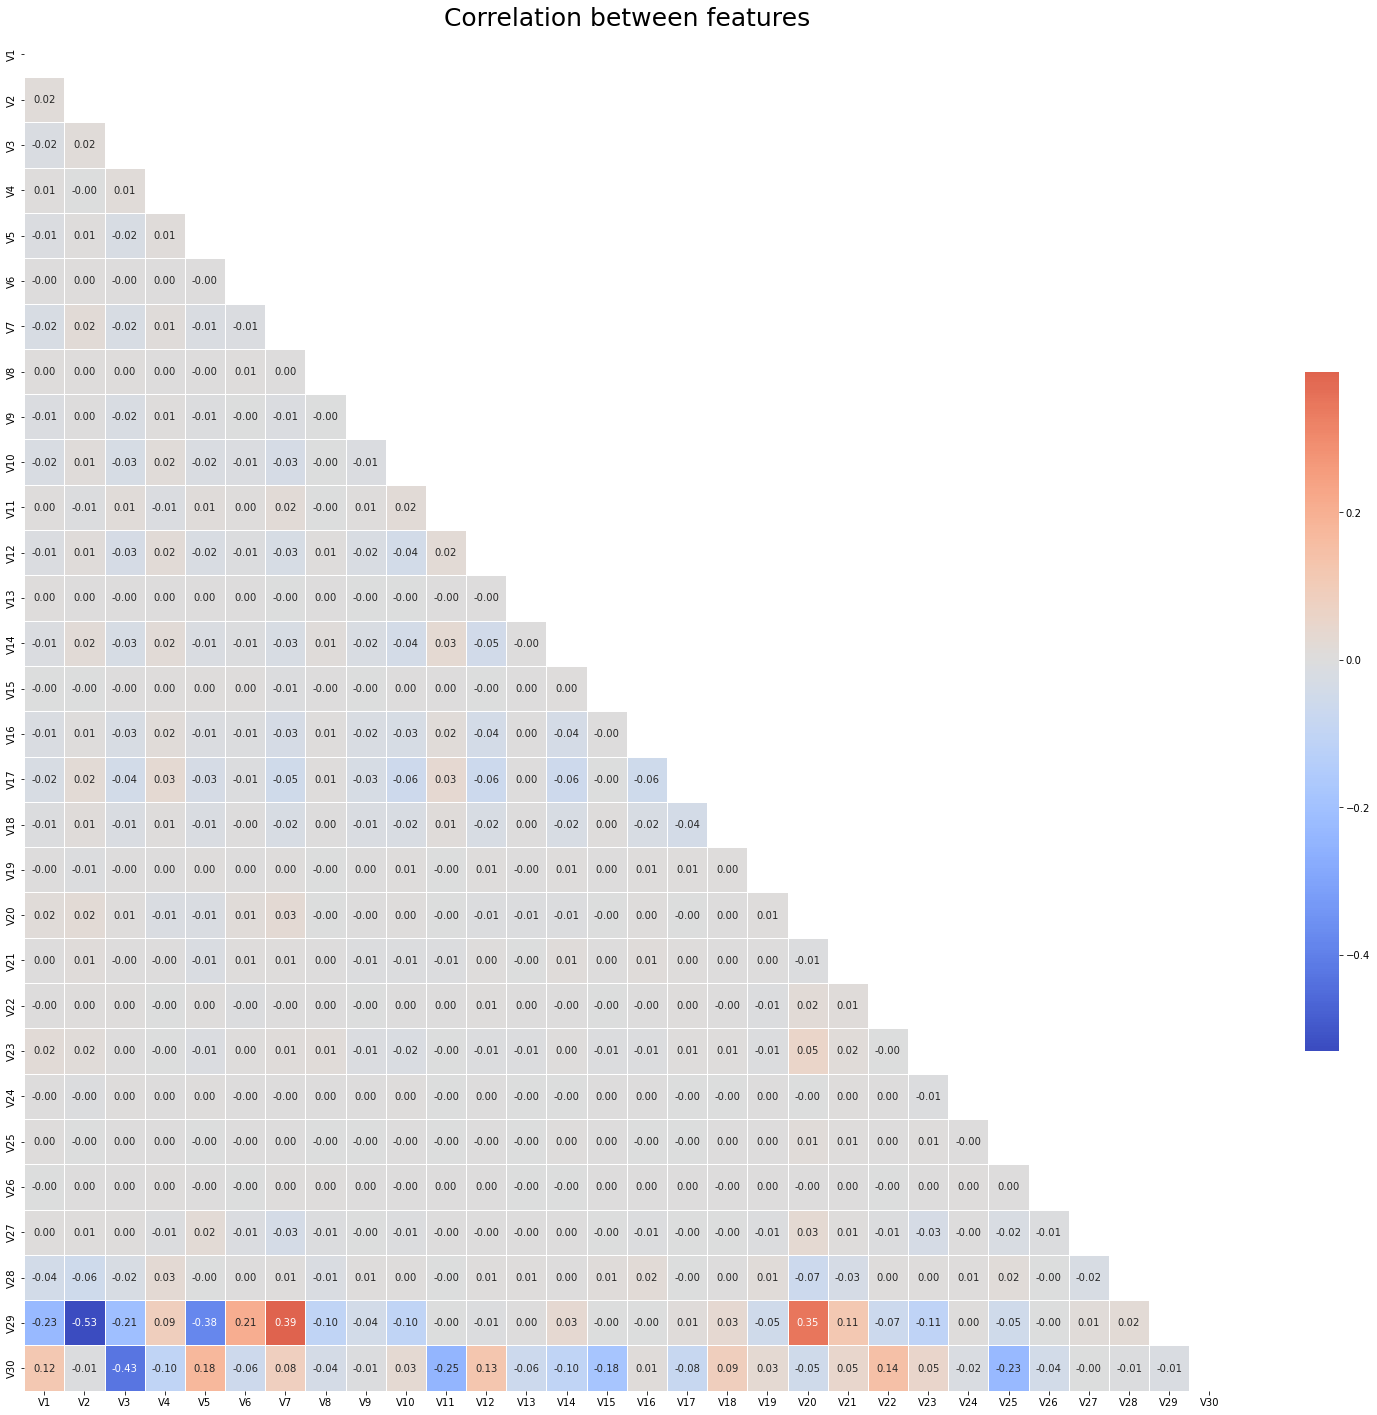

In [179]:
corr = train.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(27, 25))
sns.heatmap(data=corr,  mask=mask, annot=True, fmt='.2f', center=0,
            linewidths=0.5, cmap='coolwarm', cbar_kws={'shrink': .5})
plt.title('Correlation between features', fontsize=25)

`-` V29, V30 변수를 제외하면 변수끼리의 상관관계는 없다

`-` V30은 분포가 종모양이 아니므로 제외할 것이고 V29는 다른 변수와의 상관관계가 높아 다른 변수들로 표현 가능하므로 제외할 것이다

- 사기 데이터에 대한 상관계수 히트맵

Text(0.5, 1.0, 'Correlation between features')

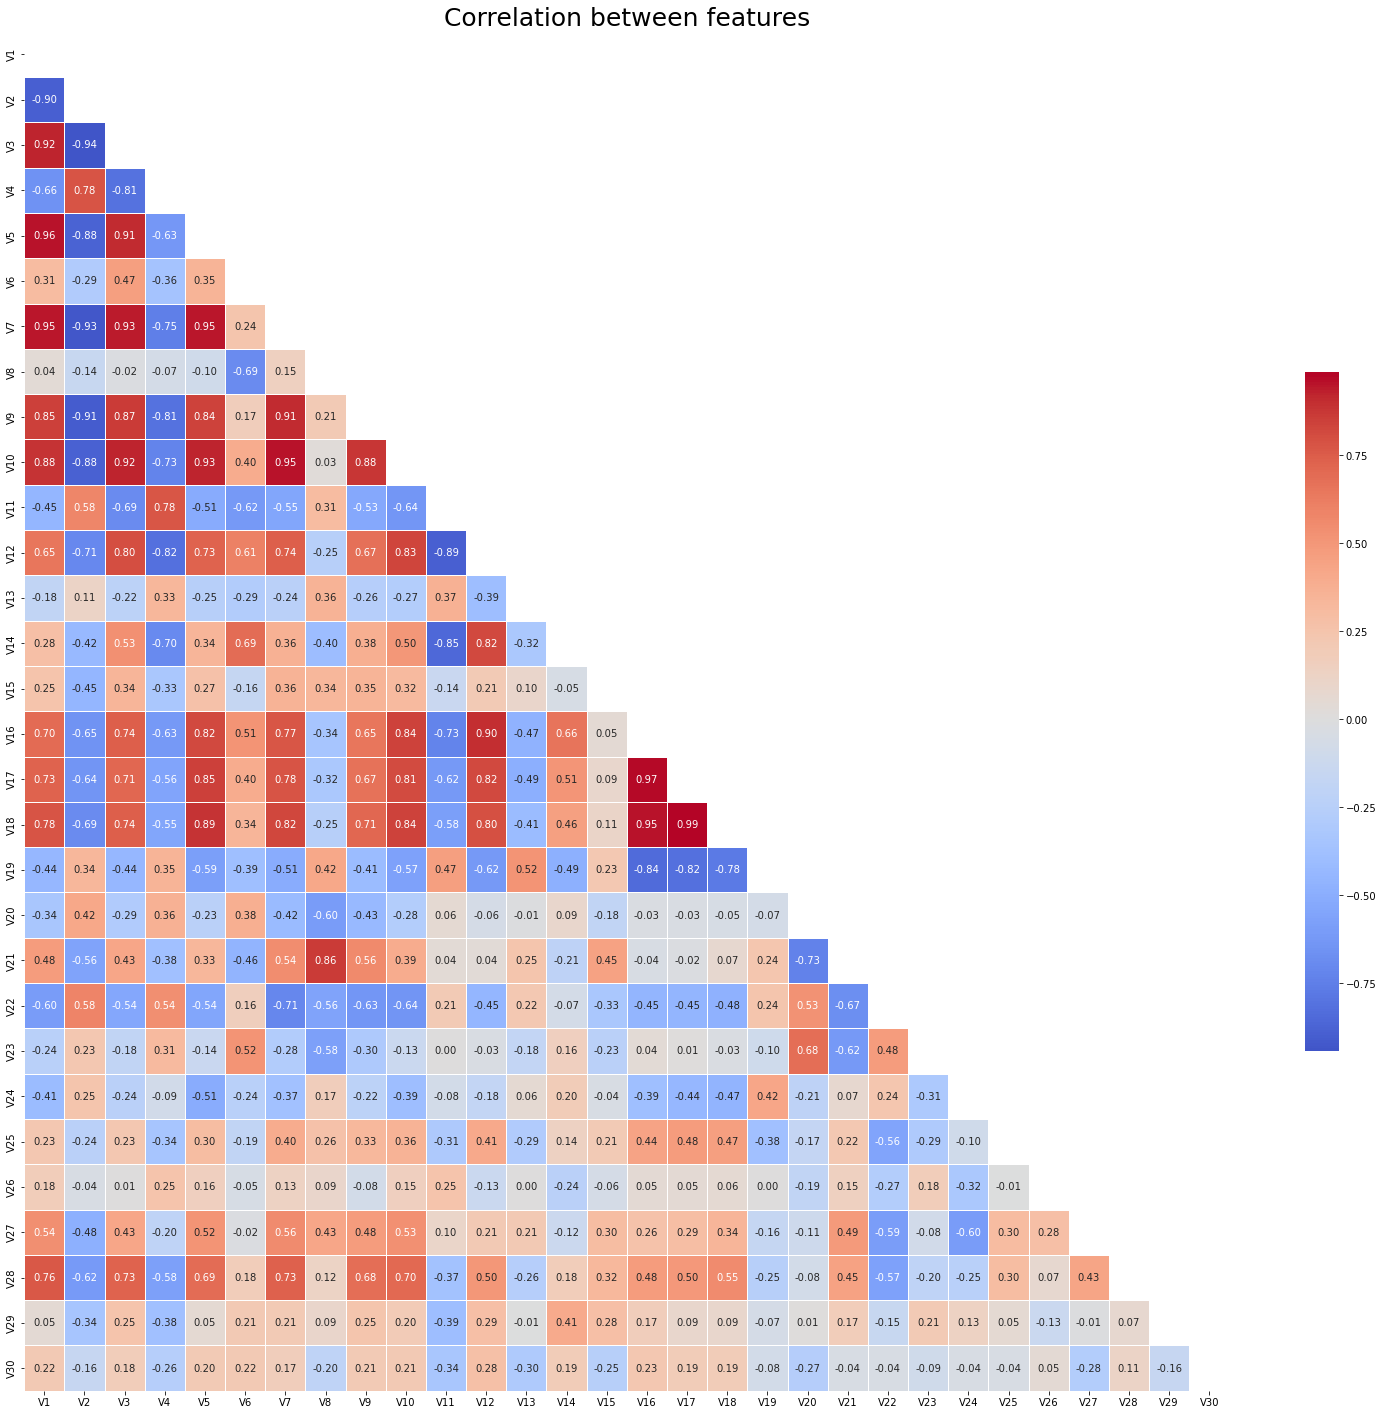

In [43]:
corr = valid[valid['Class'] == 1].drop('Class', axis=1).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(27, 25))
sns.heatmap(data=corr,  mask=mask, annot=True, fmt='.2f', center=0,
            linewidths=0.5, cmap='coolwarm', cbar_kws={'shrink': .5})
plt.title('Correlation between features', fontsize=25)

`-` 정상 데이터의 경우 변수끼리의 상관관계가 없었다 (정상 데이터만 가지고 해봤는데 상관관계 거의 없었음)

`-` 사기 데이터의 경우 변수끼리의 상관관계가 존재한다 (V17과 V18 간의 상관계수는 0.99)

- 다중공선성 판단

`-` 로지스틱 회귀를 통해 다중공선성을 판단하자

`-` 시도해봤는데 sigular matrix라서 모형 적합도 안된다

`-` 매우 심한 다중공선성 존재

`-` 근데 어차피 회귀모형은 안 쓸것이라서 괜찮을 듯 하다

- t-SNE, PCA 산점도

In [91]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [61]:
features = ['V14', 'V17', 'V12', 'V10', 'V11', 'V16', 'V9', 'V18', 'V7', 'V3', 'V4']

In [92]:
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)

In [64]:
%%time
data = tsne.fit_transform(valid[features])

Wall time: 3min 54s


In [93]:
data2 = pca.fit_transform(valid[features])

In [94]:
data = pd.DataFrame(data=data, columns=['V1', 'V2'])
data2 = pd.DataFrame(data=data2, columns=['V1', 'V2'])

In [95]:
data['Class'] = valid['Class']
data2['Class'] = valid['Class']

Text(0.5, 1.0, 'PCA')

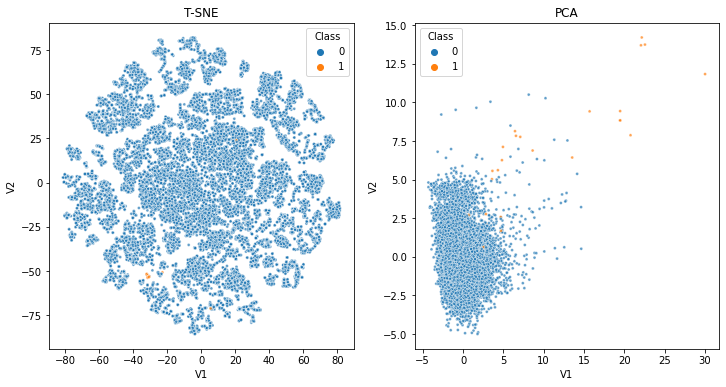

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=data, x='V1', y='V2', hue='Class', marker='.', alpha=0.7, ax=ax1)
sns.scatterplot(data=data2, x='V1', y='V2', hue='Class', marker='.', alpha=0.7, ax=ax2)

ax1.set_title('T-SNE')
ax2.set_title('PCA')

## 변수 중요도

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
target = valid['Class']
X_valid = valid.drop(['V29', 'V30', 'Class'], axis=1)

In [12]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=6)
rfc.fit(X_valid, target)

RandomForestClassifier(max_depth=6, n_estimators=500)

In [13]:
_ = pd.DataFrame(dict(zip(rfc.feature_names_in_, rfc.feature_importances_)), index = [0]).T.\
reset_index().rename(columns = {'index':'feature', 0:'importance'}).\
sort_values('importance', ascending = False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

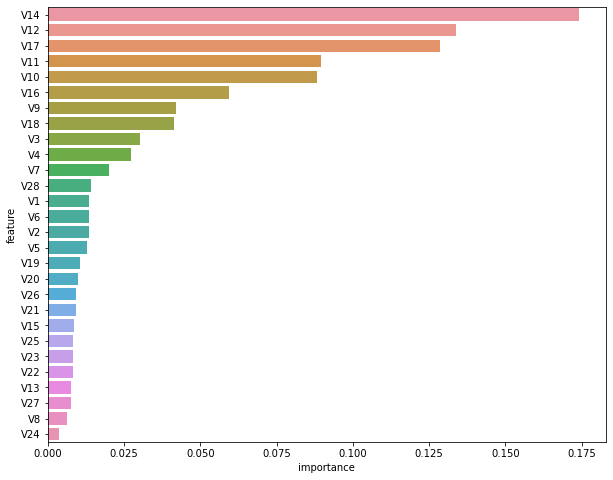

In [14]:
plt.figure(figsize=(10, 8))
sns.barplot(y = 'feature', x = 'importance', data = _)

`-` 변수 중요도가 $0.02$보다 작은 것은 거의 도움이 되지 않는다고 판단해 삭제하겠다

`-` 중요하지 않은 변수가 많으면 공분산을 판단할 때 좋지 않은 영향을 끼칠 수 있다

`-` overfit 문제도 생길 수 있다

## 비지도 학습

`-` 참고: https://www.kaggle.com/code/drscarlat/compare-6-unsupervised-anomaly-detection-models

In [68]:
from sklearn.metrics import f1_score, classification_report
from scipy.stats import multivariate_normal
from sklearn.covariance import EllipticEnvelope, MinCovDet
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

`-` 사기 데이터는 원래 데이터의 변동성을 크게하므로 스케일링하는데 포함하지 않을 것이다

`-` 스케일링 하든 안하든 비슷함 (왜냐하면 사기 데이터의 개수가 너무 적음, 또한 정상 데이터와 사기 데이터의 차이가 무지막지하게 크지도 않음)

In [6]:
SEED = 2022

In [7]:
valid['Class'].value_counts()

0    28432
1       30
Name: Class, dtype: int64

- 사기 데이터 비율에 대한 95% 신뢰구간

`-` 표본크기가 충분므로 정규성을 가정하겠다

In [335]:
n = valid.shape[0]
p = 30 / n
z = 1.96
error = np.sqrt(p*(1 - p) / n)
print([p - z*error, p + z*error])

[0.0006770535134139938, 0.0014310204097115772]


`-` 사기 데이터 비율에 대한 95% 신뢰구간은 $(0.000677, 0.001431)$이다

`-` valid_contamination을 $\frac{30}{28432 + 30}$보다 더 크게 설정했다

`-` 이상치 탐지 모델 중에서 `EllipticEnvelope`의 성능이 가장 뛰어나 이를 기준으로 삼았다

`-` 근데 `EllipticEnvelope`의 경우 contamination을 valid의 사기 데이터 비율로 설정하면 모형이 과소추정하는 경향이 있다

`-` valid의 사기 데이터 개수는 30개인데 train으로 학습하고 valid로 검정하면 사기 데이터 개수는 대략 26개로 추정한다

`-` 이는 train의 사기 데이터 비율이 valid의 사기 데이터 비율보다 크기 때문이다

`-` 동일한 contamination을 기준으로 train의 사기 데이터는 valid의 사기 데이터보다 더 극단적인 값에 해당한다

`-` train의 데이터 수가 valid의 데이터 수보다 많으므로 이는 합당한 이유로 볼 수 있다

`-` 게다가 contamination은 표본비율이므로 샘플링할 때마다 달라지므로 신뢰구간안에 있는 값이면 충분히 모비율이 될 수 있다

- EllipticEnvelope

`-` 다변량 정규 분포를 가정하여 데이터 분포에 타원을 fitting한다 (중심에 가까울수록 밀도가 높고 멀어질수록 밀도가 낮다)

`-` 마할라노비스 거리를 이용 (유클리드 거리는 각 변수의 분산을 고려하지 않는데 마할라노비스 거리는 분산을 고려한다)

`-` 예컨대 변수 $X_1$의 분포는 $-1000\sim 1000$의 값을 가지고 $X_2$의 분포는 $-100\sim 100$의 값을 가진다고 하자

`-` $X_1$에서 $-10$과 $10$ 사이의 거리와 $X_2$에서 $-10$과 $10$ 사이의 거리는 $20$으로 동일하지만 $X_1$이 더 넓게 퍼져있으므로 $X_1$에서의 $-10$과 $10$ 사이의 거리가 더 가깝다고 할 수 있다

`-` 이를 고려한 것이 마할라노비스 거리이다

`-` 아무튼, 이어서 말하면 타원에서 벗어날수록 outlier이다 (밀도가 낮아지니까)

`-` 오염되지 않은 원래 데이터의 최소 공분산 행렬식을 얻기위해 기존에 데이터에서 샘플링할 비율을 정하자 (support_fraction)

`-` 전체 데이터에서 샘플링 비율만큼 데이터를 추출, 이를 효율적으로 여러번 수행하여 각 그룹에서 공분산 행렬식을 구하고 최소값을 MCD로 추정

`-` support_fraction에 따라 f1 score가 천차만별이다 (값이 클수록 수행시간 오래걸림)

`-` support_fraction이 높을수록 f1 score가 안정적으로 나온다 (support_fraction이 조금 달라진다고 f1 score에 큰 차이가 있지 않다)

`-` 참고: https://stats.stackexchange.com/questions/475636/intuitive-explanation-of-minimum-covariance-determinant-mcd

`-` 참고: https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

`-` 참고: https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py

In [261]:
# features = ['V14', 'V17', 'V12', 'V10', 'V11', 'V16', 'V9', 'V18', 'V7', 'V3', 'V4'] ## 랜덤 포레스트에서 변수중요도가 0.02보다 큰 변수 목록

In [262]:
features = ['V1', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] ## 정상 분포와 사기 분포가 서로 겹치지 않는 변수 목록 (성능 가장 좋음)

In [265]:
valid_contamination = 340 / (284320 + 340)
valid_contamination 

0.0011944073631700977

`-` V29와 V30만 drop 했을 때보다 성능이 약간 더 좋다 

`-` support_fraction에 따른 valid 데이터에 대한 f1 score

`-` $p$에 대한 95% 신뢰구간 내의 값을 contamination으로 사용하자

In [266]:
f1_score_dict  = {}

In [267]:
for sf in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    cov = EllipticEnvelope(support_fraction=sf, contamination=valid_contamination, assume_centered=False, random_state=SEED)
    cov.fit(train[features])
    y_pred = cov.predict(valid[features])
    y_pred[y_pred == 1] = 0 ## 정상
    y_pred[y_pred == -1] = 1 ## 비정상
    f1_score_dict[sf] = [f1_score(valid['Class'], y_pred, average='macro'), len(y_pred[y_pred == 1])]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:45<00:00, 38.38s/it]


In [268]:
f1_score_dict 

{0.1: [0.9137051774467988, 28],
 0.2: [0.7961028726986173, 24],
 0.3: [0.9165787375726882, 30],
 0.4: [0.9165787375726882, 30],
 0.5: [0.9165787375726882, 30],
 0.6: [0.9165787375726882, 30],
 0.7: [0.9165787375726882, 30],
 0.8: [0.8927516353661109, 26],
 0.9: [0.8927516353661109, 26]}

`-` support_fraction이 약간 변한다고 f1 score가 변하지 않는 값으로 support_fraction을 설정하자

`-` assume_centered는 False로 설정하는 것이 성능면에서 더 낫다 

In [307]:
cov = EllipticEnvelope(support_fraction=0.6, contamination=valid_contamination, assume_centered=False, random_state=SEED)

In [308]:
%%time
cov.fit(train[features])

Wall time: 34.9 s


EllipticEnvelope(contamination=0.0011944073631700977, random_state=2022,
                 support_fraction=0.6)

In [309]:
y_pred = cov.predict(valid[features])

In [310]:
y_pred[y_pred == 1] = 0 ## 정상
y_pred[y_pred == -1] = 1 ## 비정상

In [311]:
len(y_pred[y_pred == 1])

30

In [312]:
print(classification_report(valid['Class'], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.83      0.83      0.83        30

    accuracy                           1.00     28462
   macro avg       0.92      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462



In [313]:
f1_score(valid['Class'], y_pred, average='macro')

0.9165787375726882

`-` 성능은 아주 우수하다

- scatter plot

`-` 실제 데이터의 이상점과 예측한 이상점을 시각화하자

In [314]:
X = train[features]
X2 = valid[features]

In [329]:
def show_outlier(data: pd.DataFrame, robust_cov, label=None) -> None:
    y_pred = robust_cov.predict(data)
    y_pred[y_pred == 1] = 0 ## 정상
    y_pred[y_pred == -1] = 1 ## 비정상
    
    ## 시각화
    if label is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        normal_idx = label[label == 0].index
        fraud_idx = label[label == 1].index
    else:
        fig, ax1 = plt.subplots(figsize=(10, 5))

    ## Prediction
    inlier_plot = ax1.scatter(data.loc[y_pred == 0, 'V12'], data.loc[y_pred == 0, 'V18'], color="black", alpha=0.6, label="inliers")
    outlier_plot = ax1.scatter(
        data.loc[y_pred == 1, 'V12'], data.loc[y_pred == 1, 'V18'], color="red", alpha=0.6, label="outliers"
    )
    ax1.legend()
    ax1.set_title('Prediction')
    
    ## Real
    if label is not None:
        inlier_plot = ax2.scatter(data.loc[normal_idx, 'V12'], data.loc[normal_idx, 'V18'], color="black", alpha=0.6, label="inliers")
        outlier_plot = ax2.scatter(
            data.loc[fraud_idx, 'V12'], data.loc[fraud_idx, 'V18'], color="red", alpha=0.6, label="outliers"
        )
        ax2.legend()
        ax2.set_title('Real')

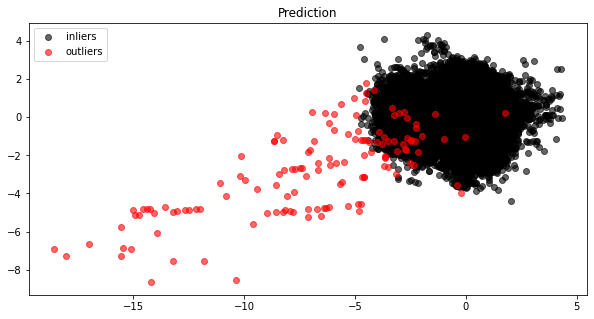

In [330]:
show_outlier(X, cov)

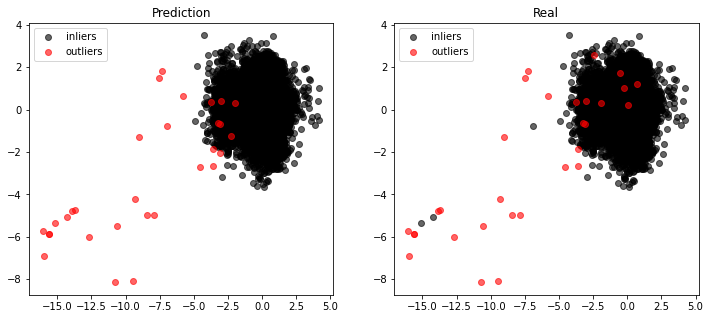

In [331]:
show_outlier(X2, cov, valid['Class'])

- box plot

`-` train은 라벨이 없는 관계로 valid만 시각화

In [318]:
robust_cov = MinCovDet().fit(X2)

In [319]:
## Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = cov.mahalanobis(X2 - robust_cov.location_) ** (0.33)

In [320]:
normal_idx = valid[valid['Class'] == 0].index
fraud_idx = valid[valid['Class'] == 1].index

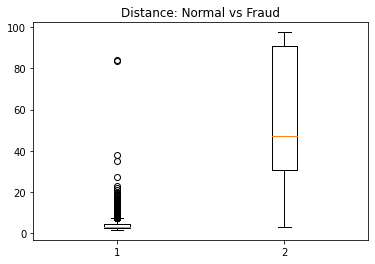

In [321]:
plt.boxplot([robust_mahal[normal_idx], robust_mahal[fraud_idx]])
plt.title('Distance: Normal vs Fraud')
plt.show()

- predict test

In [322]:
test_pred = cov.predict(test[features])

In [323]:
test_pred[test_pred == 1] = 0 ## 정상
test_pred[test_pred == -1] = 1 ## 비정상

In [324]:
submission['Class'] = test_pred

In [325]:
sum(test_pred)

322

In [304]:
# submission.to_csv('./Data/submission20.csv', index=False)

- 더 해볼 것

`-` 샘플링 비율 다르게 하고 앙상블하기

`-` 다른 모델과 앙상블하기

`-` 쓸모없어 보이는 피쳐 드랍하기 (score 차이는 없지만 support_fraction에 따른 차이가 작아졌다)

- IsolationForest

In [116]:
model = IsolationForest(n_estimators=300, max_samples=len(train), contamination=valid_contamination, random_state=SEED, verbose=0)
model.fit(train[features])

IsolationForest(contamination=0.0011944073631700977, max_samples=113842,
                n_estimators=300, random_state=2022)

In [212]:
y_pred = model.predict(valid[features])

In [118]:
y_pred[y_pred == 1] = 0 ## 정상
y_pred[y_pred == -1] = 1 ## 비정상

In [119]:
len(y_pred[y_pred == 1])

30

In [120]:
print(classification_report(valid['Class'], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.57      0.57      0.57        30

    accuracy                           1.00     28462
   macro avg       0.78      0.78      0.78     28462
weighted avg       1.00      1.00      1.00     28462



In [121]:
f1_score(valid['Class'], y_pred, average='macro')

0.7831047176889889

`-` 성능은 나쁘지 않다

- OneClassSVM

In [122]:
OneSVM = OneClassSVM(nu=valid_contamination)
OneSVM.fit(train[features])

OneClassSVM(nu=0.0011944073631700977)

In [123]:
y_pred = OneSVM.predict(valid[features])

In [176]:
y_pred[y_pred == 1] = 0 ## 정상
y_pred[y_pred == -1] = 1 ## 비정상

In [125]:
len(y_pred[y_pred == 1])

232

In [126]:
print(classification_report(valid['Class'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.09      0.70      0.16        30

    accuracy                           0.99     28462
   macro avg       0.55      0.85      0.58     28462
weighted avg       1.00      0.99      1.00     28462



In [127]:
f1_score(valid['Class'], y_pred, average='macro')

0.5782113354103791

`-` 성능은 별로다

- multivariate_normal

`-` 다변량 정규분포 사용

`-` 중심에서 멀어질수록 이상점

In [128]:
X_train = train[features]
X_valid = valid[features]

In [129]:
prob = multivariate_normal(mean=np.mean(X_train, axis=0), cov=np.cov(X_train.T))

In [130]:
x_valid = prob.pdf(X_valid)

In [131]:
x_normal = prob.pdf(X_valid[valid.Class == 0])
print('max prob of x on normal X_valid', np.max(x_normal))
print('mean prob of x on normal X_valid', np.mean(x_normal))
print('-' * 60)


x_fraud = prob.pdf(X_valid[valid.Class == 1])
print('max prob of x on fraud_pca_data', np.max(x_fraud))
print('mean prob of x on fraud_pca_data', np.mean(x_fraud))
print('-' * 60)

print('Difference between mean prob of Normal vs Fraud ', np.mean(x_normal) - np.mean(x_fraud))

max prob of x on normal X_valid 8.825207775706084e-07
mean prob of x on normal X_valid 8.430562451222492e-08
------------------------------------------------------------
max prob of x on fraud_pca_data 8.389610637103196e-08
mean prob of x on fraud_pca_data 2.855378027684976e-09
------------------------------------------------------------
Difference between mean prob of Normal vs Fraud  8.145024648453995e-08


In [182]:
eps = 1e-140

In [183]:
y_pred = (x_valid <= eps)
print(f1_score(valid['Class'], y_pred, average='macro'))

0.7914908455822022


`-` 성능은 나쁘지 않다

- LocalOutlierFactor

In [342]:
lof = LocalOutlierFactor(n_neighbors=200, contamination=valid_contamination, novelty=True)

In [343]:
%%time
lof.fit(train[features])

Wall time: 3min 50s


LocalOutlierFactor(contamination=0.001159318461268224, n_neighbors=200,
                   novelty=True)

In [344]:
%%time
y_pred = lof.predict(valid[features])
y_pred[y_pred == 1] = 0 ## 정상
y_pred[y_pred == -1] = 1 ## 비정상

Wall time: 58.4 s


In [345]:
print(classification_report(valid['Class'], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.70      0.70      0.70        30

    accuracy                           1.00     28462
   macro avg       0.85      0.85      0.85     28462
weighted avg       1.00      1.00      1.00     28462



In [346]:
len(y_pred[y_pred == 1])

30

In [347]:
print(f1_score(valid['Class'], y_pred, average='macro'))

0.8498417276308385


`-` 성능은 나쁘지 않지만 `n_neighbors`가 커질수록 모형을 적합시키는데 시간이 너무 오래걸린다